# Baseline

> This module groups the methods related to the baseline estimation.

In [ ]:
#| default_exp baseline

In [ ]:
#| export
#| hide
import inspect
import xarray as xr

In [ ]:
#| hide
import matplotlib.pyplot as plt
from raincell import open_cml_sample, open_gauge_sample
from raincell import wetdry

In [ ]:
cml = open_cml_sample()

## Last dry step as baseline

We will implement the simplest possible model, which consists of assuming that the baseline is constant and equal to the last step classified as dry. This algorithm only requires past time steps, which makes it very suitable for real-time rainfall estimation. In addition, it is very easy to compute, which makes it suitable for low-resource computation. So let's say we have the following time series for a sublink:

In [ ]:
#| echo:false
ex_att = [59, 60, 90, 75, 59, 58, 59, 80]
ex_att

[59, 60, 90, 75, 59, 58, 59, 80]


And lets assume that our wet/dry classification model classified the data as:

In [ ]:
#| echo:false
ex_wet = ["dry" if v < 70 else "wet" for v in ex_att]
ex_wet

['dry', 'dry', 'wet', 'wet', 'dry', 'dry', 'dry', 'wet']

Then the baseline would be:

In [ ]:
#| echo:false
ex_bl = []
for val, wd in zip(ex_att, ex_wet): ex_bl.append(ex_bl[-1] if wd == "wet" else val)
class Md:
    def __init__(self, h, r): self.h = h; self.r = r
    def _repr_markdown_(self): return "| Attenuation | Wet/Dry | Baseline |\n|---|---|---|\n" + "\n".join([f"| {hi} | {wi} | {bi} |" for hi, wi, bi in self.r])
Md("t", zip(ex_att, ex_wet,ex_bl))

| Attenuation | Wet/Dry | Baseline |
|---|---|---|
| 59 | dry | 59 |
| 60 | dry | 60 |
| 90 | wet | 60 |
| 75 | wet | 60 |
| 59 | dry | 59 |
| 58 | dry | 58 |
| 59 | dry | 59 |
| 80 | wet | 59 |

In [ ]:
#| hide
link = cml.isel(cml_id=0).dropna(dim="sublink_id", how="all")
link

<xarray.Dataset> Size: 308kB
Dimensions:      (sublink_id: 2, time: 2964)
Coordinates:
  * sublink_id   (sublink_id) <U3 24B '0_0' '0_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat   float64 8B 3.993
    site_0_lon   float64 8B 9.787
    site_1_lat   float64 8B 3.977
    site_1_lon   float64 8B 9.792
    transmitter  (sublink_id) float64 16B 0.0 1.0
    length       float64 8B 1.852e+03
    cml_id       <U19 76B '3.984686N-9.789517E'
Data variables:
    rsl_avg      (sublink_id, time) float64 47kB -48.0 -48.0 ... -46.4 -46.4
    tsl_avg      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
    rsl_min      (sublink_id, time) float64 47kB -48.8 -48.3 ... -46.5 -46.7
    tsl_min      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
    rsl_max      (sublink_id, time) float64 47kB -47.6 -47.8 ... -46.2 -46.2
    tsl_max      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| hide
att = (link["tsl_max"] - link["rsl_max"]).to_dataset(name="tsl_max-rsl_max")
att["tsl_min-rsl_min"] = link["tsl_min"] - link["rsl_min"]
att


<xarray.Dataset> Size: 119kB
Dimensions:          (sublink_id: 2, time: 2964)
Coordinates:
  * sublink_id       (sublink_id) <U3 24B '0_0' '0_1'
  * time             (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-...
    frequency        (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat       float64 8B 3.993
    site_0_lon       float64 8B 9.787
    site_1_lat       float64 8B 3.977
    site_1_lon       float64 8B 9.792
    transmitter      (sublink_id) float64 16B 0.0 1.0
    length           float64 8B 1.852e+03
    cml_id           <U19 76B '3.984686N-9.789517E'
Data variables:
    tsl_max-rsl_max  (sublink_id, time) float64 47kB 57.6 57.8 ... 56.2 56.2
    tsl_min-rsl_min  (sublink_id, time) float64 47kB 58.8 58.3 ... 56.5 56.7

In [ ]:
#| hide
wet = wetdry.schleiss_n_berne_2010_nms_adapted(link)
wet

<xarray.DataArray 'wet' (sublink_id: 2, time: 2964)> Size: 6kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(2, 2964))
Coordinates:
  * sublink_id   (sublink_id) <U3 24B '0_0' '0_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat   float64 8B 3.993
    site_0_lon   float64 8B 9.787
    site_1_lat   float64 8B 3.977
    site_1_lon   float64 8B 9.792
    transmitter  (sublink_id) float64 16B 0.0 1.0
    length       float64 8B 1.852e+03
    cml_id       <U19 76B '3.984686N-9.789517E'
Attributes:
    long_name:  wet_dry_classification
    method:     schleiss_n_berne_2010_adapted_to_nms_min_max_sampling

In [ ]:
#| hide
dry = ~wet
dry

<xarray.DataArray 'wet' (sublink_id: 2, time: 2964)> Size: 6kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(2, 2964))
Coordinates:
  * sublink_id   (sublink_id) <U3 24B '0_0' '0_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat   float64 8B 3.993
    site_0_lon   float64 8B 9.787
    site_1_lat   float64 8B 3.977
    site_1_lon   float64 8B 9.792
    transmitter  (sublink_id) float64 16B 0.0 1.0
    length       float64 8B 1.852e+03
    cml_id       <U19 76B '3.984686N-9.789517E'
Attributes:
    long_name:  wet_dry_classification
    method:     schleiss_n_berne_2010_adapted_to_nms_min_max_sampling

In [ ]:
#| hide
dry_att = att.where(dry)
dry_att

<xarray.Dataset> Size: 119kB
Dimensions:          (sublink_id: 2, time: 2964)
Coordinates:
  * sublink_id       (sublink_id) <U3 24B '0_0' '0_1'
  * time             (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-...
    frequency        (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat       float64 8B 3.993
    site_0_lon       float64 8B 9.787
    site_1_lat       float64 8B 3.977
    site_1_lon       float64 8B 9.792
    transmitter      (sublink_id) float64 16B 0.0 1.0
    length           float64 8B 1.852e+03
    cml_id           <U19 76B '3.984686N-9.789517E'
Data variables:
    tsl_max-rsl_max  (sublink_id, time) float64 47kB 57.6 57.8 ... 56.2 56.2
    tsl_min-rsl_min  (sublink_id, time) float64 47kB 58.8 58.3 ... 56.5 56.7

In [ ]:
#| hide
baseline = dry_att.ffill(dim="time")
baseline

<xarray.Dataset> Size: 119kB
Dimensions:          (sublink_id: 2, time: 2964)
Coordinates:
  * sublink_id       (sublink_id) <U3 24B '0_0' '0_1'
  * time             (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-...
    frequency        (sublink_id) float64 16B 1.505e+04 1.456e+04
    site_0_lat       float64 8B 3.993
    site_0_lon       float64 8B 9.787
    site_1_lat       float64 8B 3.977
    site_1_lon       float64 8B 9.792
    transmitter      (sublink_id) float64 16B 0.0 1.0
    length           float64 8B 1.852e+03
    cml_id           <U19 76B '3.984686N-9.789517E'
Data variables:
    tsl_max-rsl_max  (sublink_id, time) float64 47kB 57.6 57.8 ... 56.2 56.2
    tsl_min-rsl_min  (sublink_id, time) float64 47kB 58.8 58.3 ... 56.5 56.7

In [ ]:
#| hide
for v in baseline.data_vars:
    attrs = baseline[v].attrs
    attrs["long_name"] = getattr(attrs, "long_name", v) + "_baseline"    
    attrs["method"] = "last_dry_step"

In [ ]:
#| exports
def get_bl_as_last_dry_step(
        att: xr.Dataset, # ds containing the raw attenuation variables
        wet: xr.DataArray # da containing wet events as booleans
        ) -> xr.Dataset: # ds containing the baseline of all the attenuation variables in the input
    """Create a baseline based on the last dry step before the each wet event."""
    baseline = att.where(~wet).ffill(dim="time")
    for v in baseline.data_vars:
        attrs = baseline[v].attrs
        attrs["long_name"] = getattr(attrs, "long_name", v) + "_baseline"    
        attrs["method"] = inspect.currentframe().f_code.co_name
    return baseline

In [ ]:
#| echo:false
wet = wetdry.schleiss_n_berne_2010_nms_adapted(cml)
att = (cml["tsl_max"] - cml["rsl_max"]).to_dataset(name="tsl_max-rsl_max")
att["tsl_min-rsl_min"] = cml["tsl_min"] - cml["rsl_min"]
baseline = get_bl_as_last_dry_step(att, wet)
baseline

/home/inigo/Documents/1_projects/raincell/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


KeyError: 'wet'

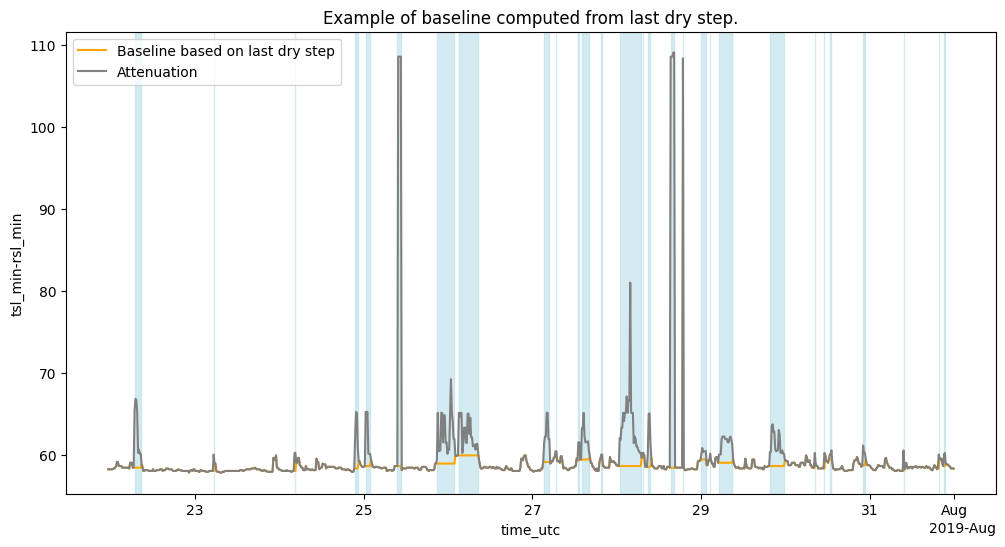

In [ ]:
#| echo:false
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
v="tsl_min-rsl_min"
isel = dict(cml_id=0, sublink_id=0, time=slice(-10*24*4, None))
baseline[v].isel(**isel).plot(ax=ax, label="Baseline based on last dry step", color="orange");
att[v].isel(**isel).plot(ax=ax, label="Attenuation", color="grey")
ax.fill_between(wet.isel(**isel)["time"], 0, 1, where=wet.isel(**isel), color='lightblue', alpha=0.5, transform=ax.get_xaxis_transform())
ax.legend()
ax.set_title(f"Example of baseline computed from last dry step.");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()